In [1970]:
import asyncio
from datetime import datetime, timedelta
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import re
from tqdm.asyncio import tqdm_asyncio

import csv
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

## Data Scraping

- Get links to scrape

In [846]:
links = [
    'https://www.trivago.com.my/en-MY/odr/hotels-kuala-lumpur-malaysia?search=200-55488',
    'https://www.trivago.com.my/en-MY/odr/hotels-malacca-malaysia?search=200-55700',
    'https://www.trivago.com.my/en-MY/odr/hotels-kota-kinabalu-malaysia?search=200-55975',
    'https://www.trivago.com.my/en-MY/odr/hotels-genting-highlands-malaysia?search=200-55757',
    'https://www.trivago.com.my/en-MY/odr/hotels-johor-bahru-malaysia?search=200-55507',
    'https://www.trivago.com.my/en-MY/odr/hotels-ipoh-malaysia?search=200-55891',
    'https://www.trivago.com.my/en-MY/odr/hotels-kuantan-malaysia?search=200-55813',
    'https://www.trivago.com.my/en-MY/odr/hotels-kuching-malaysia?search=200-56107',
    'https://www.trivago.com.my/en-MY/odr/hotels-georgetown-malaysia?search=200-55866',
    'https://www.trivago.com.my/en-MY/odr/hotels-putrajaya-malaysia?search=200-56207',
]

In [961]:
results = []

- Start scraping

In [ ]:
# Base link with placeholders
base_link = "https://www.trivago.com.my/en-MY/srl/{city}?search=200-{search};dr-{checkin}-{checkout}-s;rc-{rooms}-{guests}"

# List of city data
cities = [
    {"city": "hotels-kuala-lumpur-malaysia", "search": "55488"},
    {"city": "hotels-malacca-malaysia", "search": "55700"},
    {"city": "hotels-kota-kinabalu-malaysia", "search": "55975"},
    {"city": "hotels-genting-highlands-malaysia", "search": "55757"},
    {"city": "hotels-johor-bahru-malaysia", "search": "55507"},
    {"city": "hotels-ipoh-malaysia", "search": "55891"},
    {"city": "hotels-kuantan-malaysia", "search": "55813"},
    {"city": "hotels-kuching-malaysia", "search": "56107"},
    {"city": "hotels-georgetown-malaysia", "search": "55866"},
    {"city": "hotels-putrajaya-malaysia", "search": "56207"},
]

async def scrape_hotels():
    async with async_playwright() as p:
        # for city_data in tqdm_asyncio(cities[1:]):
        for x in tqdm_asyncio(range(2,10)):
            browser = await p.chromium.launch(headless=False)
            context = await browser.new_context()
            page = await context.new_page()

            cur_city = cities[x]["city"].replace("hotels-", "").replace("-malaysia", "").replace("-", " ").title()
            search_id = cities[x]["search"]

            start_date = datetime(2025, 1, x+1)
            end_date = datetime(2025, 12, 31)
            current_date = start_date

            while current_date <= end_date:
                checkin_date = current_date.strftime("%Y%m%d")
                checkout_date = (current_date + timedelta(days=1)).strftime("%Y%m%d")

                # Loop through room and guest combinations
                for rooms in range(1, 4):
                    for guests in range(rooms, 4):
                        url = base_link.format(
                            city=cities[x]["city"],
                            search=search_id,
                            checkin=checkin_date,
                            checkout=checkout_date,
                            rooms=rooms,
                            guests=guests,
                        )
                        
                        print(f"Fetching data for {cur_city} - {url}")
                        
                        try:
                            await page.goto(url)
                            # Wait for the hotel list to load
                            await page.wait_for_selector('ol[data-testid="accommodation-list"]')
                            hotels = await page.query_selector_all('li[data-testid="accommodation-list-element"]')
                            
                            success_count = 0

                            for hotel in hotels[:5]:  # Limit to 5 hotels
                                try:
                                    # Click on the hotel button
                                    hotel_btn = await hotel.query_selector('button[data-testid="item-name"]')
                                    if hotel_btn:
                                        await hotel_btn.click()
                                        await page.wait_for_timeout(1000)

                                    # Click on the info button
                                    info_btn = await hotel.query_selector('button[data-testid="INFO"]')
                                    if info_btn:
                                        await info_btn.click()
                                        await page.wait_for_timeout(1000)

                                    # Extract the page content
                                    content = await page.content()
                                    soup = BeautifulSoup(content, 'html.parser')

                                    hotel_list = soup.find_all("li", {"data-testid": "accommodation-list-element"})
                                    
                                    for hotel in hotel_list[:5]:
                                        # Extract hotel details using BeautifulSoup
                                        hotel_name = hotel.select_one('button[data-testid="item-name"] span[itemprop="name"]')
                                        price = hotel.select_one('span[data-testid="recommended-price"]')
                                        accommodation = hotel.select_one('button[data-testid="accommodation-type"]')
                                        dis_label = hotel.select_one('span[class="wcZPz9"]')
                                        highlight = hotel.select_one('div[class="iDhCak"]')
                                        rating = hotel.select_one('meta[itemprop="ratingValue"]')
                                        user_rating = hotel.select_one('meta[itemprop="ratingCount"]')
                                        user_avg = hotel.select_one('span[itemprop="ratingValue"]')
                                        user_comment = hotel.select_one('h2[class*="RZr6Ly"]')

    
                                        amenities = [amenity.text for amenity in soup.select('section[data-testid="amenities-module"] li[class="k3Ip8D"]')]
    
                                        # Print or store the extracted details
                                        result = {
                                            "name": hotel_name.text if hotel_name else "",
                                            "price_per_night": price.text if price else "",
                                            "accommodation_type": accommodation.text if accommodation else "",
                                            "distance_label": dis_label.text if dis_label else "",
                                            "highlights_section": highlight.text if highlight else "",
                                            "hotel_rating": rating['content'] if rating else "",
                                            "user_rating_count": user_rating['content'] if user_rating else "",
                                            "user_average_rating": user_avg.text if user_avg else "",
                                            "user_comment": user_comment.text if user_comment else "",
                                            "amenities": amenities,
                                            "country": "Malaysia",
                                            "city": cur_city,
                                            "checkin": checkin_date,
                                            "checkout": checkout_date,
                                            "rooms": rooms,
                                            "guests": guests,
                                        }
                                        results.append(result)
    
                                        success_count += 1

                                except Exception as e:
                                    print(f"Error processing hotel: {e}")

                                if success_count >= 5:
                                    break

                        except Exception as e:
                            print(f"Error fetching data for {cur_city}: {e}")

                current_date += timedelta(days=10)

            await context.close()
            await browser.close()
            print(f'City {cur_city} completed.')

# Run the scraper
task = asyncio.create_task(scrape_hotels())
await task


In [1018]:
len(results)

10616

- Save to a csv file

In [1020]:
csv_file = "hotels_data.csv"
with open(csv_file, mode="w", newline="", encoding="utf-8") as file:
    fieldnames = ['name', 'price_per_night', 'accommodation_type', 'distance_label',
                  'highlights_section', 'hotel_rating', 'user_rating_count',
                  'user_average_rating', 'user_comment', 'amenities', 'country',
                  'city', 'checkin', 'checkout', 'rooms', 'guests']
    
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    
    for hotel in results:
        hotel['amenities'] = ', '.join(hotel['amenities'])
        writer.writerow(hotel)

print(f"Data saved to {csv_file}")

Data saved to hotels_data.csv


## Data Preprocessing

In [1208]:
pd.set_option('display.max_columns', None)

In [1302]:
df = pd.read_csv('hotels_data.csv')

- Start cleaning data scraped

In [1422]:
def clean_amenities(text):
    if pd.isna(text):
        return np.nan
    return ''.join(text.split(', '))

In [1344]:
df.loc[956:2054, 'amenities'] = df.loc[956:2054, 'amenities'].apply(clean_amenities)

In [1324]:
df.loc[:955, 'amenities'] = df.loc[:955, 'amenities'].apply(clean_amenities)

In [1354]:
df['price_per_night'] = (
    df['price_per_night']
    .str.replace('RM', '', regex=False) 
    .str.replace(',', '', regex=False) 
    .str.strip() 
    .astype(float)
)

In [1356]:
df['checkin'] = pd.to_datetime(df['checkin'].astype(str), format='%Y%m%d')
df['checkout'] = pd.to_datetime(df['checkout'].astype(str), format='%Y%m%d')

In [1357]:
df['user_comment'] = df['user_comment'].dropna().str.extract(r'[0-9.]+([a-zA-Z ]+)', expand=False)

- Adding few new columns extracted from existing data

In [1358]:
df['day_of_week'] = df['checkin'].dt.day_name()
df['day_of_month'] = df['checkin'].dt.day
df['month'] = df['checkin'].dt.month

In [1479]:
custom_column_names = {
    'Free WiFi': 'free_wifi',
    'Pool': 'pool',
    'Parking': 'parking',
    'A/C': 'aircond',
    'Restaurant': 'restaurant',
    'Hotel bar': 'hotel_bar',
    'Balcony / Patio': 'balcony_patio',
    'Spa':'spa',
    'Gym':'gym',
    'Hairdryer':'hairdryer',
    'Hotel bar':'hotel_bar',
    'Kitchen / Kitchenette':'kitchen',
    'Non-smoking rooms':'non_smoking_room',
    'TV / Entertainment':'tv_ent',
    'Washing machine':'washing_machine',
}

In [1374]:
df['amenities'] = df['amenities'].fillna('').str.split(', ')

In [1376]:
unique_amenities = custom_column_names.keys()

for amenity, column_name in custom_column_names.items():
    df[column_name] = df['amenities'].apply(lambda x: 1 if amenity in x else 0)

In [1385]:
df = df.drop(columns=['amenities'])

In [1403]:
df['highlights_section'] = df['highlights_section'].notna().astype(int)

In [1558]:
holidays_dates = holidays.MY()
df['holiday_name'] = df['checkin'].apply(lambda x: holidays_dates.get(x) if x in holidays_dates else np.nan)
df['holiday'] = df['holiday_name'].notna().astype(int)

In [1483]:
df.head()

,name,price_per_night,accommodation_type,distance_label,highlights_section,hotel_rating,user_rating_count,user_average_rating,user_comment,country,city,checkin,checkout,rooms,guests,day_of_week,day_of_month,month,free_wifi,pool,parking,aircond,restaurant,hotel_bar,balcony_patio,spa,gym,hairdryer,kitchen,non_smoking_room,tv_ent,washing_machine,holiday,holiday_name
0,"Hotel Indigo Kuala Lumpur on the Park, an IHG ...",647.0,Hotel,Kuala Lumpur,1,5.0,442.0,9.0,Excellent,Malaysia,Kuala Lumpur,2025-01-01,2025-01-02,1,1,Wednesday,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,NaN
1,Dorsett Hartamas Kuala Lumpur,161.0,Hotel,Kuala Lumpur,1,4.0,3006.0,8.3,NaN,Malaysia,Kuala Lumpur,2025-01-01,2025-01-02,1,1,Wednesday,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,NaN
2,Crowne Plaza Kuala Lumpur City Centre,683.0,Entire House / Apartment,Kuala Lumpur,0,9.3,224.0,9.3,NaN,Malaysia,Kuala Lumpur,2025-01-01,2025-01-02,1,1,Wednesday,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,NaN
3,Else Kuala Lumpur,618.0,Hotel,Kuala Lumpur,1,9.5,347.0,9.5,NaN,Malaysia,Kuala Lumpur,2025-01-01,2025-01-02,1,1,Wednesday,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,NaN
4,"Hotel Indigo Kuala Lumpur on the Park, an IHG ...",647.0,Hotel,Kuala Lumpur,1,5.0,442.0,9.0,NaN,Malaysia,Kuala Lumpur,2025-01-01,2025-01-02,1,1,Wednesday,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,NaN


- Save cleaned data to a new csv file

In [1485]:
# Save the DataFrame to a CSV file
df.to_csv('cleaned_hotels_data.csv', index=False)

## Exploratory Data Analysis (EDA)

In [1578]:
df.accommodation_type.unique()

array(['Hotel', 'Entire House / Apartment', 'Serviced apartment',
       'Guesthouse', 'Motel', 'Hostel', 'Resort', 'Bed & Breakfast',
       'Camping site'], dtype=object)

In [1489]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 10616 non-null  object        
 1   price_per_night      10616 non-null  float64       
 2   accommodation_type   10616 non-null  object        
 3   distance_label       10616 non-null  object        
 4   highlights_section   10616 non-null  int32         
 5   hotel_rating         10609 non-null  float64       
 6   user_rating_count    10609 non-null  float64       
 7   user_average_rating  10609 non-null  float64       
 8   user_comment         5412 non-null   object        
 9   country              10616 non-null  object        
 10  city                 10616 non-null  object        
 11  checkin              10616 non-null  datetime64[ns]
 12  checkout             10616 non-null  datetime64[ns]
 13  rooms                10616 non-

In [1491]:
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32'])
numeric_columns.describe()

,price_per_night,highlights_section,hotel_rating,user_rating_count,user_average_rating,rooms,guests,day_of_month,month,free_wifi,pool,parking,aircond,restaurant,hotel_bar,balcony_patio,spa,gym,hairdryer,kitchen,non_smoking_room,tv_ent,washing_machine,holiday
count,10616.000000,10616.000000,10609.000000,10609.000000,10609.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000,10616.000000
mean,490.300584,0.894970,4.789820,9371.038458,8.082788,1.663244,2.331387,15.712038,6.531933,0.970705,0.965806,0.973436,0.974378,0.965335,0.908911,0.184627,0.858704,0.752449,0.173794,0.104088,0.265637,0.234552,0.031085,0.044179
std,292.658158,0.306607,1.815419,11822.947641,0.787650,0.746232,0.747184,8.808801,3.453222,0.168641,0.181735,0.160812,0.158011,0.182938,0.287749,0.388013,0.348343,0.431610,0.378950,0.305389,0.441692,0.423738,0.173556,0.205501
min,28.000000,0.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,270.000000,1.000000,4.000000,566.000000,7.600000,1.000000,2.000000,8.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,448.000000,1.000000,4.000000,5561.000000,8.200000,1.000000,2.000000,16.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,640.000000,1.000000,5.000000,15134.000000,8.700000,2.000000,3.000000,23.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,3275.000000,1.000000,10.000000,116723.000000,10.000000,3.000000,3.000000,31.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


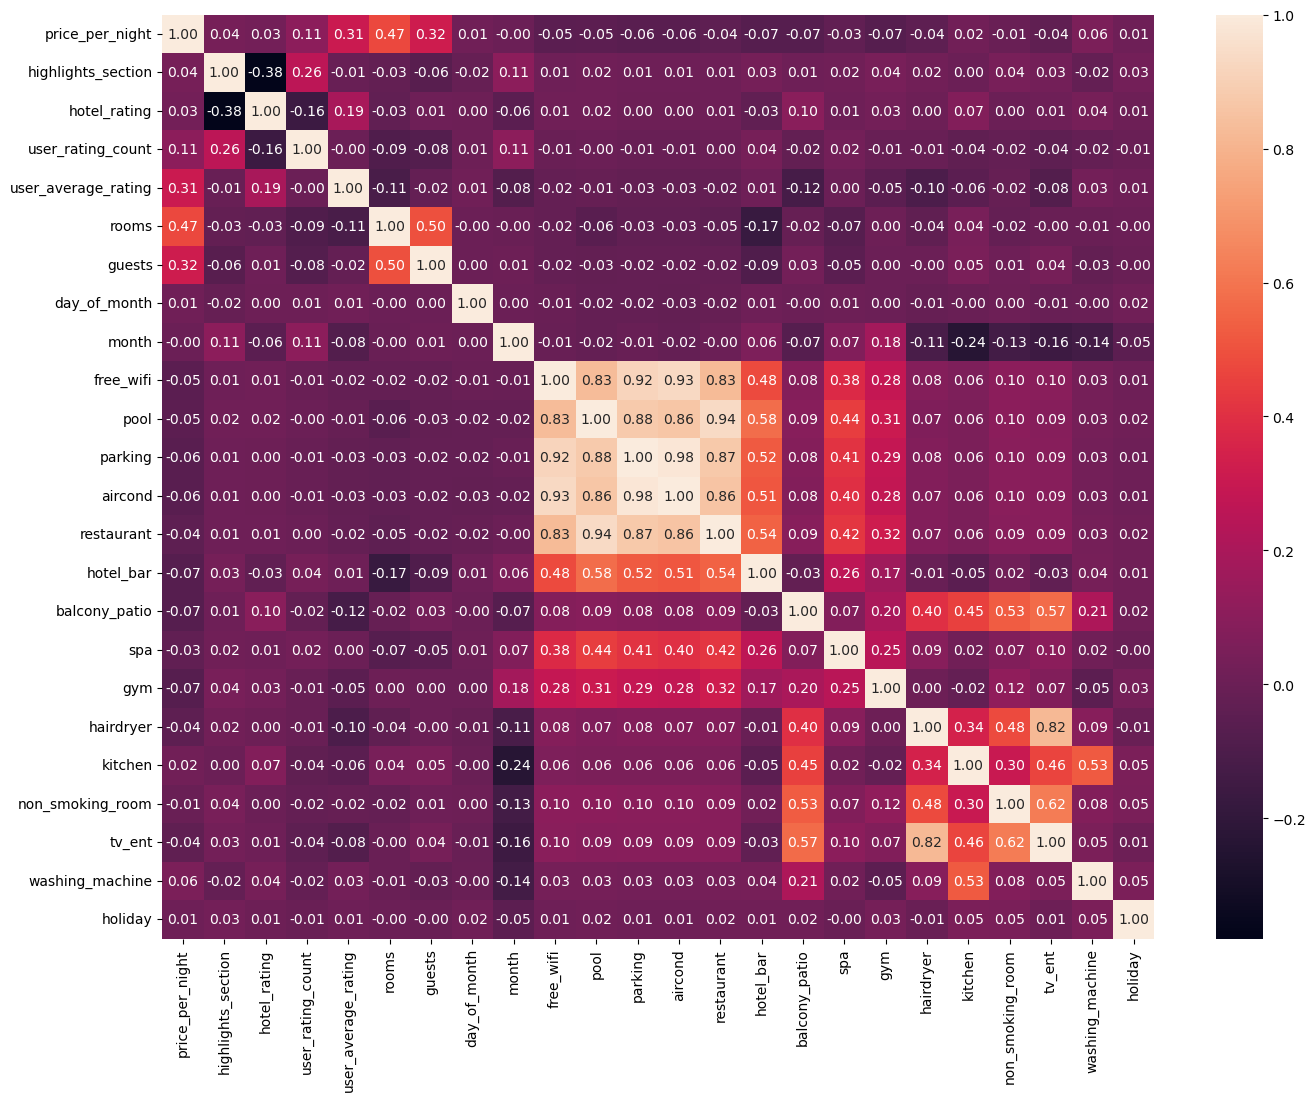

In [1518]:
correl_map = numeric_columns.corr()

plt.figure(figsize=(16,12))
sns.heatmap(correl_map, annot=True, fmt=".2f")
plt.show()

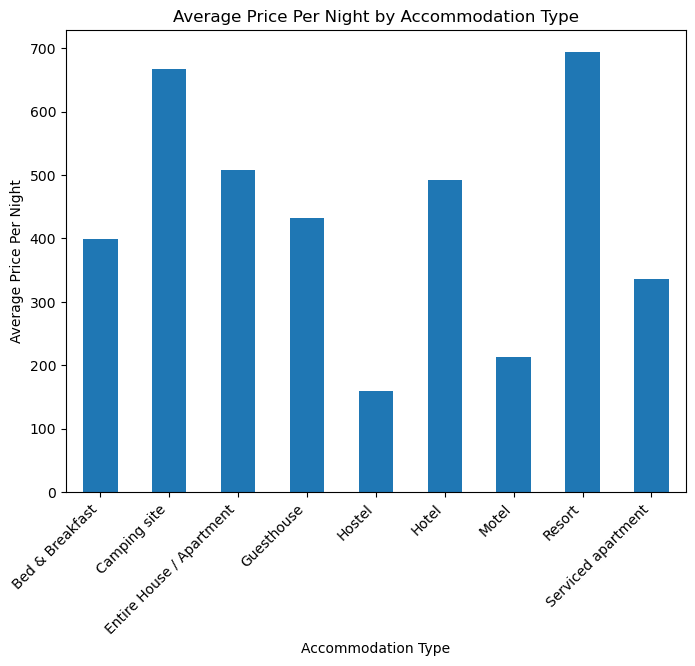

In [1654]:
plt.figure(figsize=(8, 6))

average_price_by_type = df.groupby('accommodation_type')['price_per_night'].mean()
average_price_by_type.plot(kind='bar')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Accommodation Type')
plt.ylabel('Average Price Per Night')
plt.title('Average Price Per Night by Accommodation Type')
plt.show()

The top 3 accommodation type with the highest average price per night is Resort, Camping Site, and Entire House / Apartment

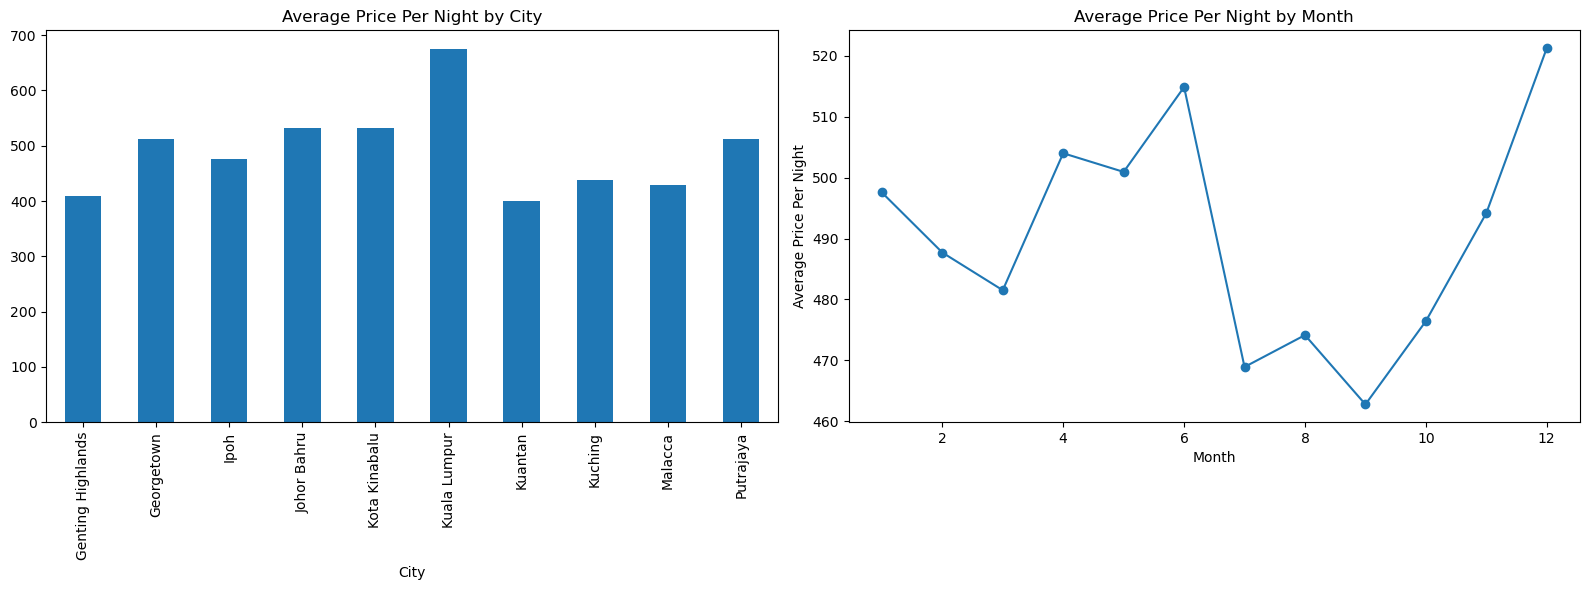

In [1592]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average price per night by month
average_price_by_month = df.groupby('month')['price_per_night'].mean()
average_price_by_month.plot(kind='line', marker='o', ax=axes[1], title='Average Price Per Night by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Price Per Night')

# Average price per night by city
average_price_by_city = df.groupby('city')['price_per_night'].mean()
average_price_by_city.plot(kind='bar', ax=axes[0], title='Average Price Per Night by City')
axes[0].set_xlabel('City')

plt.tight_layout()
plt.show()

The top 3 city with the highest average price per night is Kuala Lumpur, Johor Bahru and Kota Kinabalu. While the month with the highest average price per night is December.

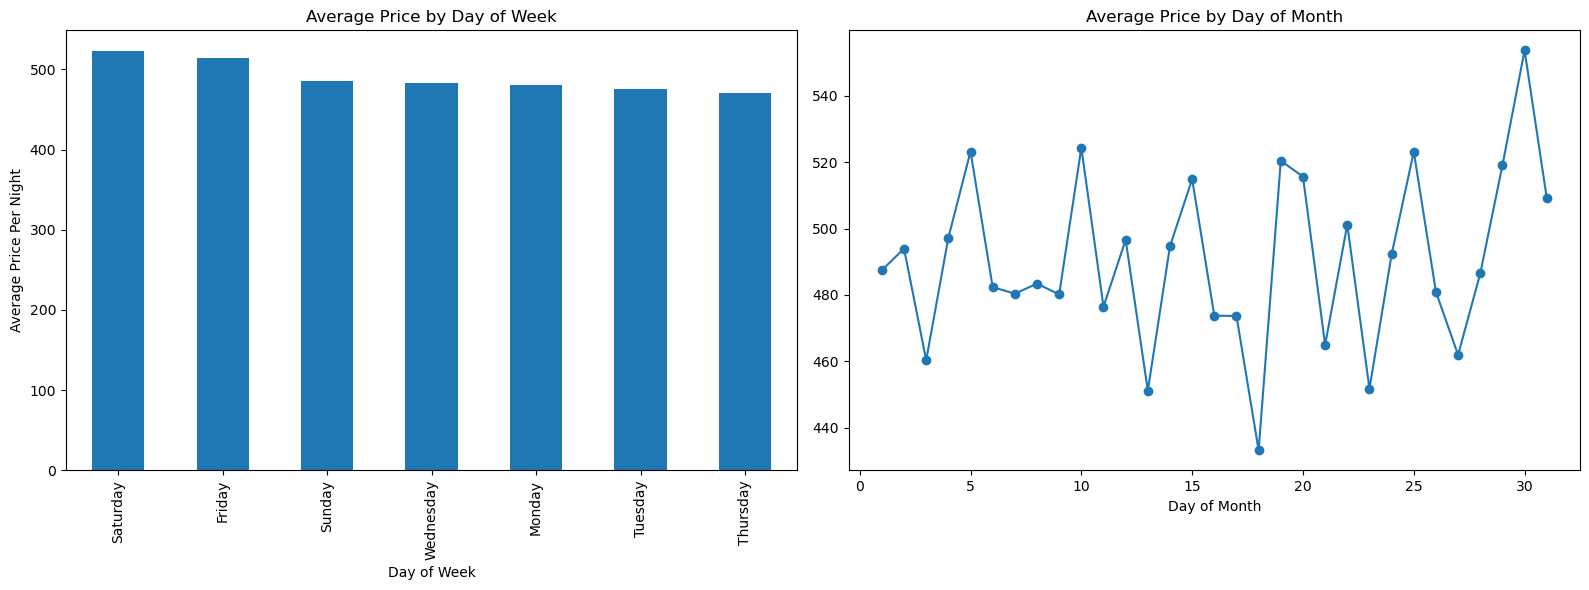

In [1590]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average price by day of week
average_price_by_day_of_week = df.groupby('day_of_week')['price_per_night'].mean().sort_values(ascending=False)
average_price_by_day_of_week.plot(kind='bar', ax=axes[0], title='Average Price by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Price Per Night')

# Average price by day of month
average_price_by_day_of_month = df.groupby('day_of_month')['price_per_night'].mean()
average_price_by_day_of_month.plot(kind='line', marker='o', ax=axes[1], title='Average Price by Day of Month')
axes[1].set_xlabel('Day of Month')

plt.tight_layout()
plt.show()

Friday and weekends have higher average price per night compared to other days of the week. While the day of month with the highest average price per night is 30th.

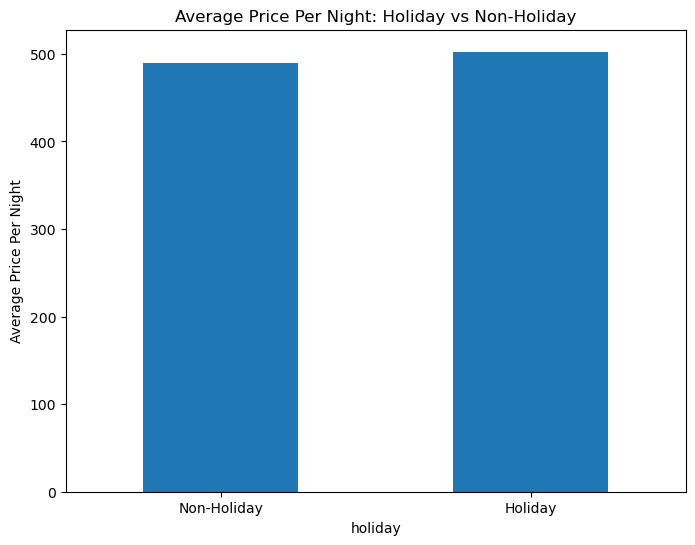

In [1594]:
average_price_holiday = df.groupby('holiday')['price_per_night'].mean()

average_price_holiday.plot(kind='bar', figsize=(8, 6), title='Average Price Per Night: Holiday vs Non-Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.ylabel('Average Price Per Night')
plt.show()

Holidays have slightly higher average price per night compared to non-holidays.

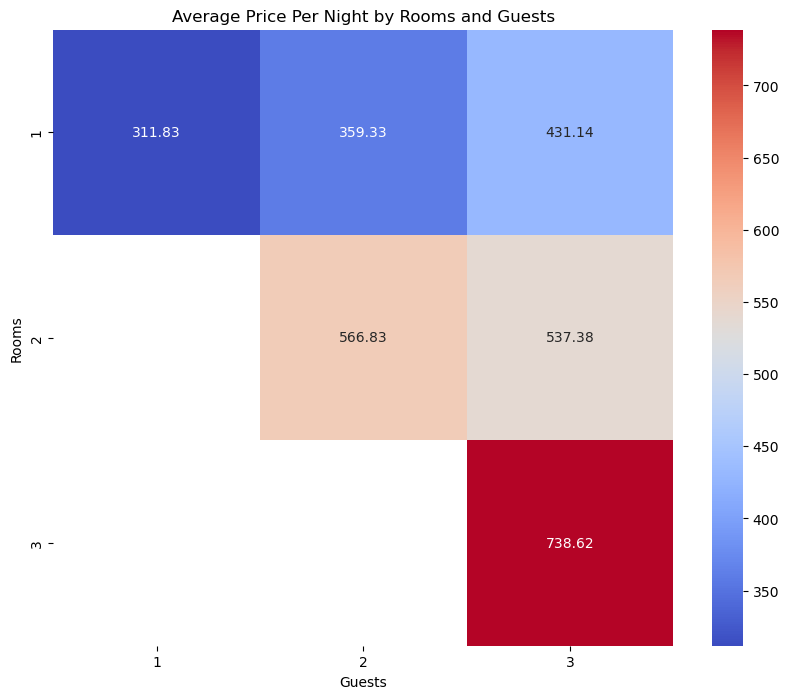

In [1616]:
# Group by room and guests
average_price_by_combination = df.groupby(['rooms', 'guests'])['price_per_night'].mean().reset_index()

# Pivot for heatmap-like visualization
pivot_table = average_price_by_combination.pivot(index='rooms', columns='guests', values='price_per_night')

# Plot as a heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Average Price Per Night by Rooms and Guests')
plt.xlabel('Guests')
plt.ylabel('Rooms')
plt.show()

Number of guests and number of rooms are directly proportional to the average price per night.

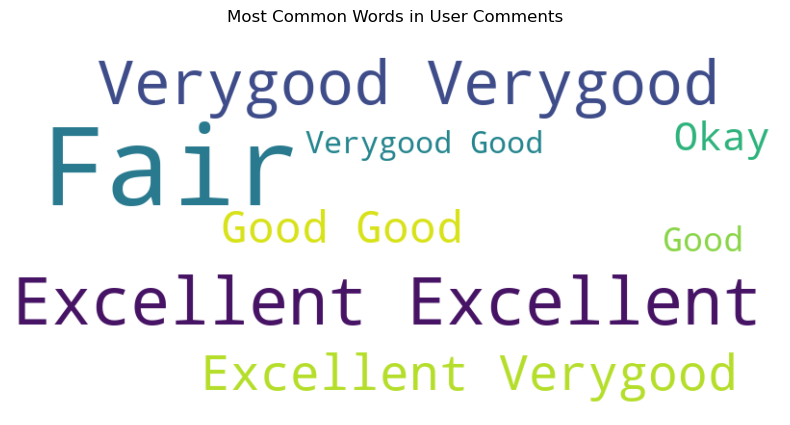

In [1702]:
# Combine all text from 'user_comment' column
all_comments = " ".join(df['user_comment'].dropna().astype(str).str.replace(r'\s+', '', regex=True))

# Word frequency
word_freq = Counter(all_comments.split())

# Word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in User Comments')
plt.show()

In [1861]:
word_freq

Counter({'Excellent': 1788,
         'Verygood': 1457,
         'Fair': 969,
         'Good': 955,
         'Okay': 243})

The most common user comment is 'Excellent' and 'Very good'

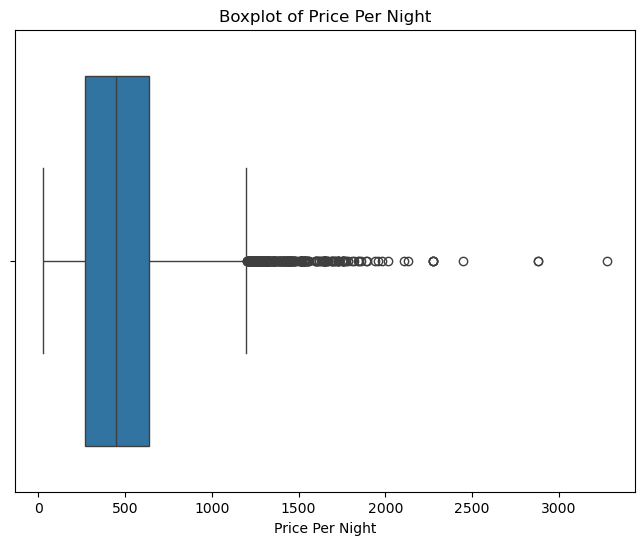

In [1658]:
# Boxplot for price_per_night
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['price_per_night'])
plt.title('Boxplot of Price Per Night')
plt.xlabel('Price Per Night')
plt.show()

Most hotel prices per night are concentrated below 500, with a few extreme outliers exceeding 1000, indicating a positively skewed distribution.

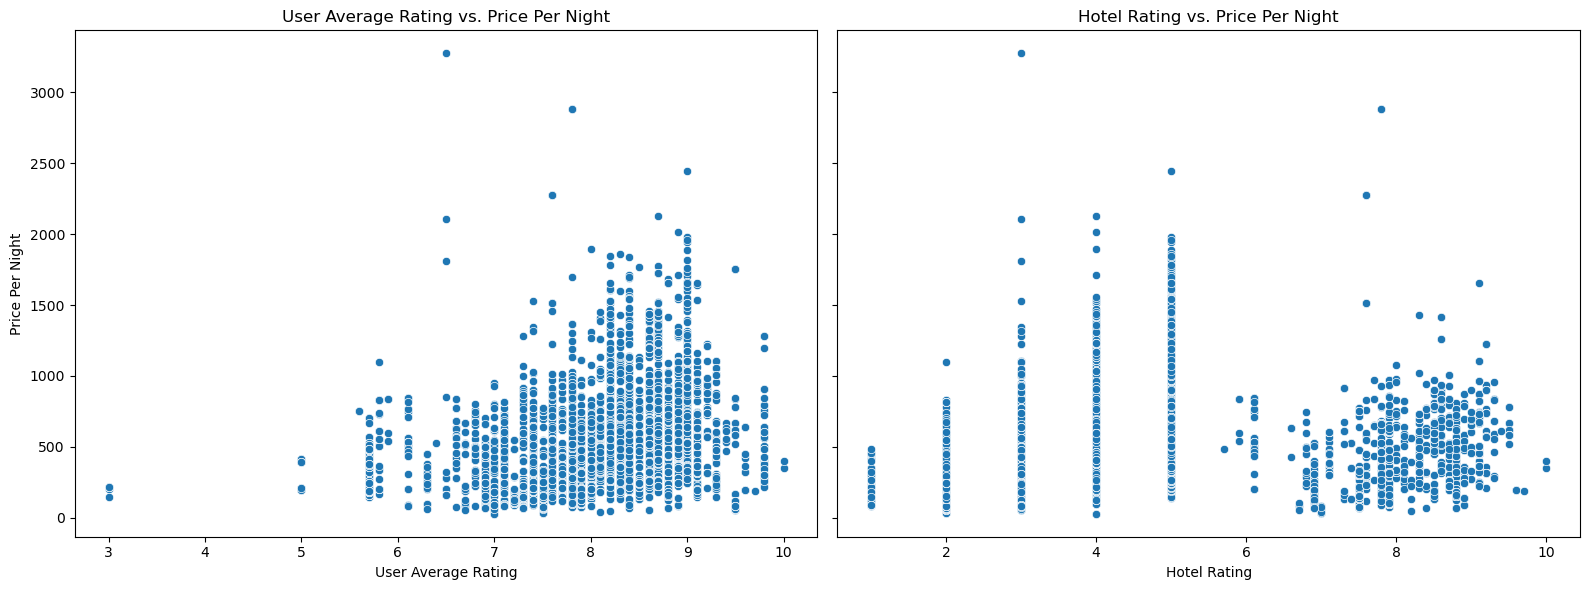

In [1662]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.scatterplot(data=df, x='user_average_rating', y='price_per_night', ax=axes[0])
axes[0].set_title('User Average Rating vs. Price Per Night')
axes[0].set_xlabel('User Average Rating')
axes[0].set_ylabel('Price Per Night')

sns.scatterplot(data=df, x='hotel_rating', y='price_per_night', ax=axes[1])
axes[1].set_title('Hotel Rating vs. Price Per Night')
axes[1].set_xlabel('Hotel Rating')
axes[1].set_ylabel('Price Per Night')

plt.tight_layout()
plt.show()

The scatterplots show a weak positive correlation between price per night and both user average ratings and hotel ratings, with higher-rated hotels generally having more expensive prices, but significant variability and outliers are present in both cases.

## Model Making

In [1896]:
df = pd.read_csv('cleaned_hotels_data.csv')

- Dropping some columns due to irrelevancy

In [1899]:
df = df.drop(columns=['holiday_name', 'month', 'day_of_month', 'day_of_week', 'user_rating_count', 'distance_label', 'highlights_section', 'name', 'user_rating_count', 'country', 'checkout'])

- Handling missing values

In [1902]:
df['user_comment'] = df['user_comment'].fillna(0)

In [1903]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price_per_night      10616 non-null  float64
 1   accommodation_type   10616 non-null  object 
 2   hotel_rating         10609 non-null  float64
 3   user_average_rating  10609 non-null  float64
 4   user_comment         10616 non-null  object 
 5   city                 10616 non-null  object 
 6   checkin              10616 non-null  object 
 7   rooms                10616 non-null  int64  
 8   guests               10616 non-null  int64  
 9   free_wifi            10616 non-null  int64  
 10  pool                 10616 non-null  int64  
 11  parking              10616 non-null  int64  
 12  aircond              10616 non-null  int64  
 13  restaurant           10616 non-null  int64  
 14  hotel_bar            10616 non-null  int64  
 15  balcony_patio        10616 non-null 

In [1924]:
# Convert datetime to numeric features
if 'checkin' in df.columns:  
    df['checkin'] = pd.to_datetime(df['checkin'])
    df['month'] = df['checkin'].dt.month
    df['day'] = df['checkin'].dt.day
    df['day_of_week'] = df['checkin'].dt.dayofweek
    df.drop(columns=['checkin'], inplace=True)

# Encode categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns.drop('price_per_night')

# Define the target column
target_column = 'price_per_night'
X = df.drop(columns=[target_column])
y = df[target_column]

# One-hot encoding for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

In [1926]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1928]:
# Convert to string
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [1930]:
# Create a pipeline with preprocessing and a model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['hotel_rating', 'user_average_rating', 'rooms', 'guests', 'free_wifi',
       'pool', 'parking', 'aircond', 'restaurant', 'hotel_bar',
       'balcony_patio', 'spa', 'gym', 'hairdryer', 'kitchen',
       'non_smoking_room', 'tv_ent', 'washing_machine', 'holiday', 'month',
       'day', 'day_of_week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['accommodation_type', 'user_comment', 'city'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [1931]:
# Hyperparameter tuning for RandomForest
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'model__max_depth': 30, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best Score: 0.8346677723140319


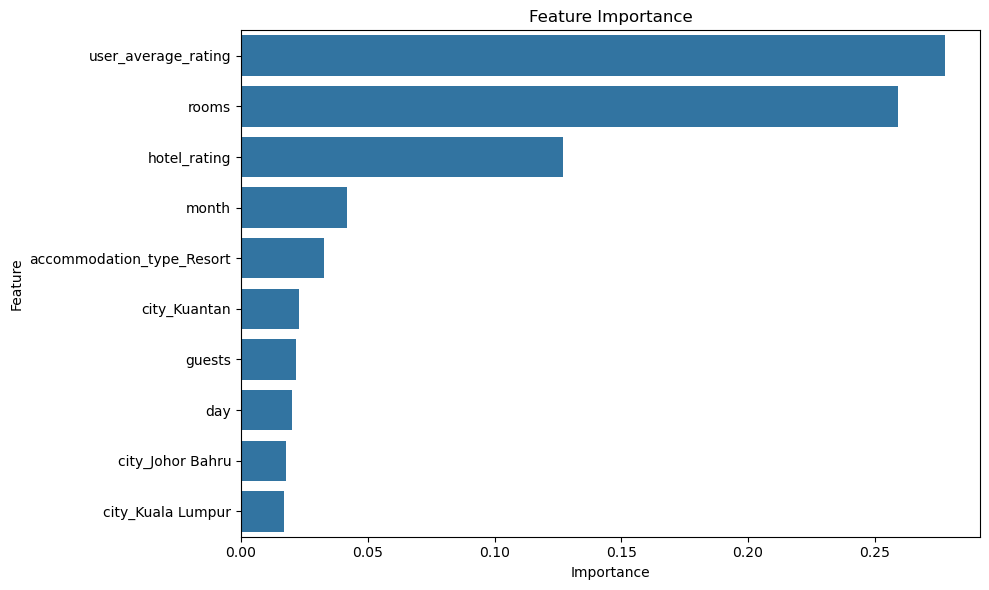

In [1947]:
# Extract feature importance
final_model = grid_search.best_estimator_.named_steps['model']
feature_names = numerical_columns.tolist() + list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())

importance = final_model.feature_importances_

# Plot feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10)) 
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [1934]:
# Predictions and evaluation
y_pred = grid_search.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 51.06890466867687
Mean Squared Error: 14927.473348319634
Root Mean Squared Error: 122.17803955015661
R² Score: 0.8296858573216669


In [1938]:
# Save the model
joblib.dump(grid_search.best_estimator_, 'hotel_price_prediction_model.pkl')

['hotel_price_prediction_model.pkl']